<a href="https://colab.research.google.com/github/Lukarusja/Owoce-i-warzywa/blob/master/Kopia_notatnika_psy_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import shutil, os
from torchvision import datasets
import torch
import torchvision.models as models
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data_dir = "/content/drive/My Drive/Dog Breed Identification/"
train_dir = data_dir + 'train_full'
test_dir = data_dir + 'test'
labels_dir = data_dir + 'labels.csv'

In [22]:
labels_df = pd.read_csv(labels_dir)
breed = labels_df["breed"].unique()
os.chdir(train_dir)
os.mkdir(train_dir + '/breed')
os.chdir(train_dir + '/breed')

for breed_type in breed:
    os.mkdir(breed_type)
    print("Directory ", breed_type, " created")

Directory  boston_bull  created
Directory  dingo  created
Directory  pekinese  created
Directory  bluetick  created
Directory  golden_retriever  created
Directory  bedlington_terrier  created
Directory  borzoi  created
Directory  basenji  created
Directory  scottish_deerhound  created
Directory  shetland_sheepdog  created
Directory  walker_hound  created
Directory  maltese_dog  created
Directory  norfolk_terrier  created
Directory  african_hunting_dog  created
Directory  wire-haired_fox_terrier  created
Directory  redbone  created
Directory  lakeland_terrier  created
Directory  boxer  created
Directory  doberman  created
Directory  otterhound  created
Directory  standard_schnauzer  created
Directory  irish_water_spaniel  created
Directory  black-and-tan_coonhound  created
Directory  cairn  created
Directory  affenpinscher  created
Directory  labrador_retriever  created
Directory  ibizan_hound  created
Directory  english_setter  created
Directory  weimaraner  created
Directory  giant_sc

In [24]:
breed = labels_df.breed.unique()

os.chdir(data_dir)
os.mkdir("valid_sorted")
os.chdir("valid_sorted")
os.mkdir("breed")
os.chdir("breed")

for breed_type in breed:
    os.mkdir(breed_type)
    print("Directory ", breed_type, " created")


Directory  boston_bull  created
Directory  dingo  created
Directory  pekinese  created
Directory  bluetick  created
Directory  golden_retriever  created
Directory  bedlington_terrier  created
Directory  borzoi  created
Directory  basenji  created
Directory  scottish_deerhound  created
Directory  shetland_sheepdog  created
Directory  walker_hound  created
Directory  maltese_dog  created
Directory  norfolk_terrier  created
Directory  african_hunting_dog  created
Directory  wire-haired_fox_terrier  created
Directory  redbone  created
Directory  lakeland_terrier  created
Directory  boxer  created
Directory  doberman  created
Directory  otterhound  created
Directory  standard_schnauzer  created
Directory  irish_water_spaniel  created
Directory  black-and-tan_coonhound  created
Directory  cairn  created
Directory  affenpinscher  created
Directory  labrador_retriever  created
Directory  ibizan_hound  created
Directory  english_setter  created
Directory  weimaraner  created
Directory  giant_sc

In [8]:
labels_df = pd.read_csv(labels_dir)
breed = labels_df["breed"].unique()
os.chdir(data_dir)

x = labels_df.id
y = labels_df.breed

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [10]:
image_count_train = x_train.shape[0]
image_count_valid = x_valid.shape[0]

In [15]:
image_count_train

8177

In [14]:
image_count_valid

2045

In [13]:
os.chdir(train_dir)

for image in x_train.index:
    breed_type = labels_df.breed[image]
    path = "breed/" + breed_type + "/"
    file = labels_df.id[image] + ".jpg"
    shutil.move(file, path)

Error: ignored

In [16]:
os.chdir(data_dir)

for image in x_valid.index:
    breed_type = labels_df.breed[image]
    path = "valid_sorted/breed/" + breed_type + "/"
    file = "train_full/" + labels_df.id[image] + ".jpg"
    shutil.move(file, path)

In [17]:
use_cuda = torch.cuda.is_available()

In [21]:
valid_dir = data_dir + 'valid_sorted'

In [22]:
# Batch size
batch_size = 16
# For faster computation, setting num_workers
num_workers = 4

# Transforms for the training, validation, and testing sets
data_transforms = {
    'train'      : transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])]),

    'valid'      : transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])]),
    'test'       : transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
}

# Loading the datasets with ImageFolder
image_datasets = {
    'train'  : datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'valid'  : datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
    'test'   : datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}

# Using the image datasets and the trainforms in defining the dataloaders
dataloaders = {
    'train' : torch.utils.data.DataLoader(image_datasets['train'], batch_size = batch_size, shuffle=True, num_workers = num_workers),
    'valid' : torch.utils.data.DataLoader(image_datasets['valid'], batch_size = batch_size),
    'test'  : torch.utils.data.DataLoader(image_datasets['test'], batch_size = batch_size)
}

In [23]:
import torchvision.models as models
import torch.nn as nn

# Loading the pretrained model
model_transfer = models.densenet161(pretrained=True)

if use_cuda:
    model_transfer = model_transfer.cuda()
    
print(model_transfer)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth



DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

In [24]:
# Freeze parameters so we don't backprop through them
for param in model_transfer.parameters():
    param.requires_grad = False
    
in_features = model_transfer.classifier.in_features
hidden_layer = 1000
out_features = 133

# Creating a custom classifier and attaching to the model
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(in_features, hidden_layer)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(p=.25)),
                          ('fc2', nn.Linear(hidden_layer, out_features)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model_transfer.classifier = classifier
model_transfer.classifier

Sequential(
  (fc1): Linear(in_features=2208, out_features=1000, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=1000, out_features=133, bias=True)
  (output): LogSoftmax(dim=1)
)

In [25]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Is GPU available: ', 'Yes' if torch.cuda.is_available() else 'No')

Is GPU available:  Yes


In [26]:
import torch.optim as optim
# Selecting the loss function and optimizer
criterion_transfer = nn.NLLLoss()

optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.003)

# Moving the model to the device
model_transfer.to(device);

In [27]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
import numpy as np
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
        
     
        # print training/validation statistics 
        print('\n-----------------------------------------------------------------------------\nEpoch: {} \nTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss has decreased from ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [28]:
loaders_transfer = dataloaders

# train the model
model_transfer = train(5, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')


-----------------------------------------------------------------------------
Epoch: 1 
Training Loss: 0.009498 	Validation Loss: 0.000000
Validation loss has decreased from (inf --> 0.000000).  Saving model ...

-----------------------------------------------------------------------------
Epoch: 2 
Training Loss: 0.000000 	Validation Loss: 0.000000
Validation loss has decreased from (0.000000 --> 0.000000).  Saving model ...

-----------------------------------------------------------------------------
Epoch: 3 
Training Loss: 0.000000 	Validation Loss: 0.000000
Validation loss has decreased from (0.000000 --> 0.000000).  Saving model ...

-----------------------------------------------------------------------------
Epoch: 4 
Training Loss: 0.000000 	Validation Loss: 0.000000
Validation loss has decreased from (0.000000 --> 0.000000).  Saving model ...

-----------------------------------------------------------------------------
Epoch: 5 
Training Loss: 0.000000 	Validation Loss: 0.

In [29]:
# load the model that got the best validation accuracy 
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

In [30]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.000000


Test Accuracy: 100% (10373/10373)


In [ ]:
model_save_name = 'psy_vgg16_27022020.pt'
path = F"drive/My Drive/{model_save_name}" 
torch.save(model_transfer.state_dict(), path)

In [31]:
import pandas as pd

#labels_df = pd.read_csv(labels_dir)
breed = labels_df["breed"].unique()
#print(breed)
class_names = [item.replace("_", " ")for item in breed]
print(class_names)

['boston bull', 'dingo', 'pekinese', 'bluetick', 'golden retriever', 'bedlington terrier', 'borzoi', 'basenji', 'scottish deerhound', 'shetland sheepdog', 'walker hound', 'maltese dog', 'norfolk terrier', 'african hunting dog', 'wire-haired fox terrier', 'redbone', 'lakeland terrier', 'boxer', 'doberman', 'otterhound', 'standard schnauzer', 'irish water spaniel', 'black-and-tan coonhound', 'cairn', 'affenpinscher', 'labrador retriever', 'ibizan hound', 'english setter', 'weimaraner', 'giant schnauzer', 'groenendael', 'dhole', 'toy poodle', 'border terrier', 'tibetan terrier', 'norwegian elkhound', 'shih-tzu', 'irish terrier', 'kuvasz', 'german shepherd', 'greater swiss mountain dog', 'basset', 'australian terrier', 'schipperke', 'rhodesian ridgeback', 'irish setter', 'appenzeller', 'bloodhound', 'samoyed', 'miniature schnauzer', 'brittany spaniel', 'kelpie', 'papillon', 'border collie', 'entlebucher', 'collie', 'malamute', 'welsh springer spaniel', 'chihuahua', 'saluki', 'pug', 'malino

In [32]:
def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    # Opening the image
    image = Image.open(img_path)
   
    # Preprocessing transforms
    preprocess_transforms = transforms.Compose([transforms.Resize(255),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406],
                                                                     [0.229, 0.224, 0.225])])
    
    # Preoprcess the image
    image = preprocess_transforms(image)
    
    # Move the tensor to the device
    image = image.to(device)
    image = image.unsqueeze(0)
    
    model_transfer.eval()
     # Turn off gradients
    with torch.no_grad():
        output = model_transfer.forward(image)
        ps = torch.exp(output)
        top_prob, top_class = ps.topk(5) 
    return top_prob, top_class 

In [33]:
import matplotlib.pyplot as plt

def run_app(img_path):
    
   # if face_detector(img_path):
    #  top_prob, top_class = predict_breed_transfer(img_path)
    #elif dog_detector(img_path):
    top_prob, top_class = predict_breed_transfer(img_path)   
    #else:
     # top_prob, top_class = 'Error'
    
    labels = []
    for classes in top_class.cpu().numpy()[0]:
        labels.append(class_names[classes])
        
    # Plotting
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))    
        
    # Test Image
    ax1.set_title(img_path)
    ax1.imshow(Image.open(img_path))
    ax1.axis('off')

    # Top 5 predictions
    ax2.set_title('Predictions')
    ax2.set_yticks(np.arange(5))
    ax2.set_yticklabels(labels)
    ax2.set_xlabel('Probability')
    ax2.invert_yaxis()
    ax2.barh(np.arange(1), top_prob.cpu()[0], xerr=0, align='center')
    ax2.set_xticklabels([])

    plt.show()

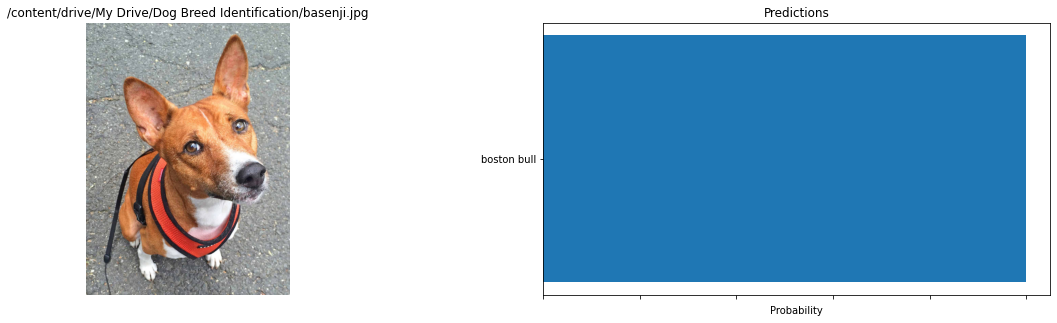

In [38]:
test_file_path = '/content/drive/My Drive/Dog Breed Identification/basenji.jpg'
run_app(test_file_path)